In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns   
import math
import time

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""

    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)

        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""

    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [3]:
import ClassifiersAndMetrics

importing Jupyter notebook from ClassifiersAndMetrics.ipynb


In [4]:
infori = pd.read_csv('data/winequality-red.csv')

In [5]:
infori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
infori.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
# interpret each of value of the qualities as a class
# and factor each of the feature as independent

(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <BarContainer object of 10 artists>)

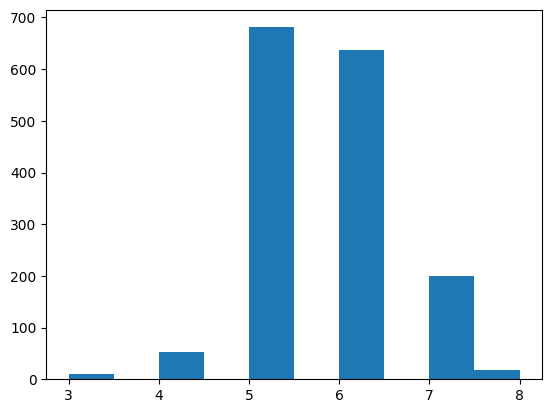

In [8]:
plt.hist(infori['quality'])

In [9]:
from sklearn.model_selection import train_test_split

inf, X_test, y_train, y_test = train_test_split(infori, infori['quality'], test_size=0.25, random_state=0)

In [10]:
# Create artificial column for quality
inf['q_3'] = inf['quality'] == 3
inf['q_4'] = inf['quality'] == 4
inf['q_5'] = inf['quality'] == 5
inf['q_6'] = inf['quality'] == 6
inf['q_7'] = inf['quality'] == 7
inf['q_8'] = inf['quality'] == 8

In [11]:
(inf['quality'] > 8).sum() + (inf['quality'] < 3).sum()

0

In [12]:
# perform previous example on this column basically

In [13]:
allY = inf[['q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8']]
inf['dummy_1'] = 1

In [14]:
# eqn changes a little bit to
# p(x) = 1/(1 + e^-(b0 + b1x1 + b2x2 ... bnxn)
# also we will need standardize all the x0...xns

def get_lin_eqn(params, xs):
    return np.dot(params, xs)

def get_p(params, xs):
    return 1/(1 + math.e**-(get_lin_eqn(params, xs)))

def get_all_p(params, ds):
    red = []
    red.append(ds.columns[-1])
    red.extend(ds.columns[:11])
    return ds[red].apply(lambda x: get_p(params, x), axis=1)

def errfuncBN(ypr, y, x=1):
    return ((ypr - y) * x).mean()

def get_fit(params, ds, ypr):
    return (Y * np.log(ypr) + (1 - Y) * np.log(1 - ypr)).sum()

def get_cost(params, ds, ypr):
    return - get_fit(params, ds, ypr) / Y.count()

In [15]:
inf.columns[0:10]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates'],
      dtype='object')

Percent taken by get_all_p single: 0.8791877660013182
Total time 4.188606023788452


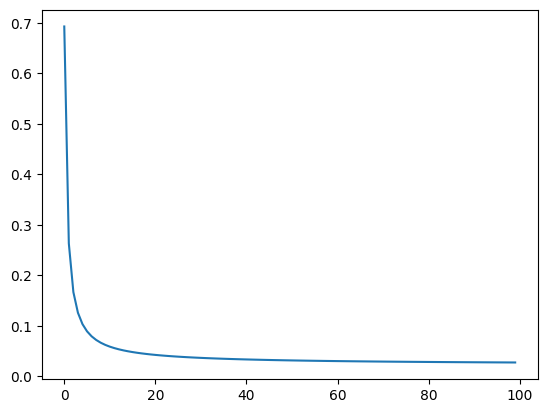

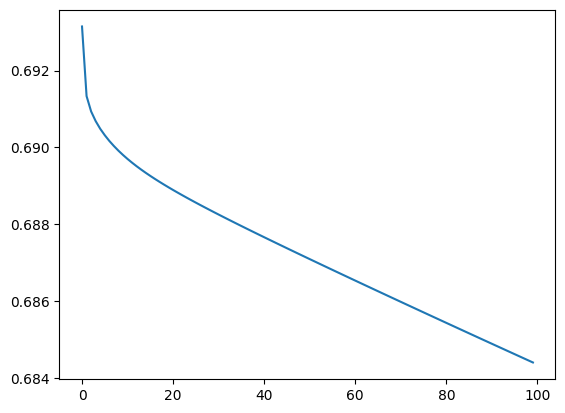

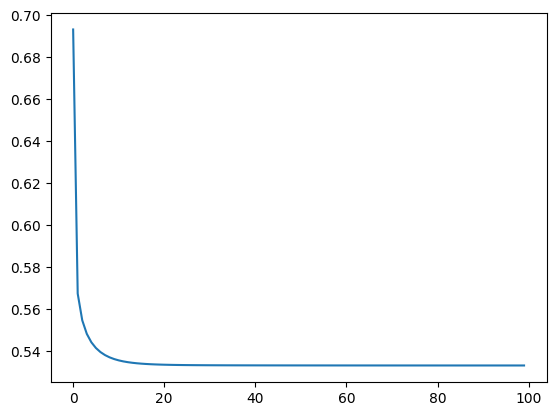

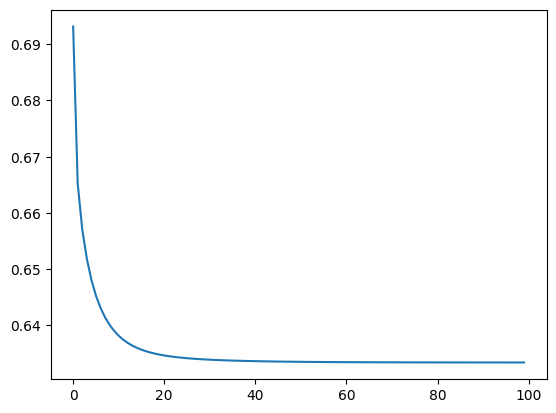

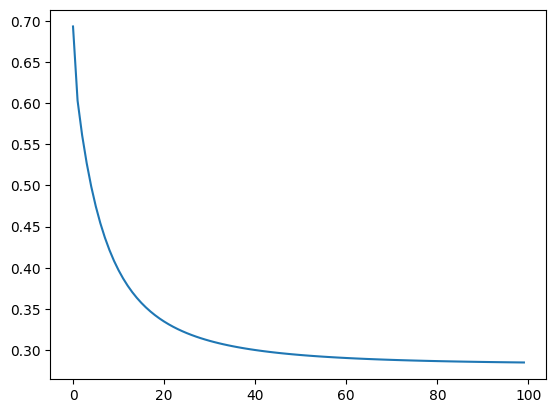

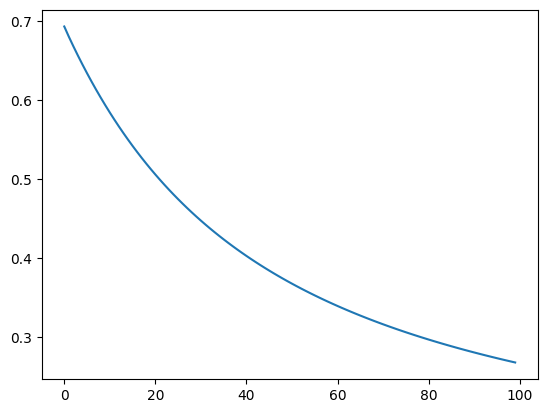

In [16]:
frac = 0
lg0 = time.time()
for i in range(0, 11):
    t3 = inf.columns[i]
    inf[t3] = (inf[t3] - inf[t3].mean()) / inf[t3].std()

params_all = []
alphas_all = [2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
i0 = 0
for t2 in allY.columns:
    Y = allY[t2]
    params = np.zeros(11 + 1)
    alpha = alphas_all[i0]
    costs = []
    fig, ax = plt.subplots()
    for i in range(100):
        #generate ypr
        pr2 = time.time()
        ypr = get_all_p(params, inf)
        res2 = time.time()
        frac += res2 - pr2
        for idx, x in np.ndenumerate(params):
            if idx == 0:
                params[0] = x - alpha * errfuncBN(ypr, Y)
            else:
                params[idx] = x - alpha * errfuncBN(ypr, Y, inf[inf.columns[idx[0] - 1]])
        rm = get_cost(params, inf, ypr)
        costs.append(rm)
    inf['p_' + t2] = get_all_p(params, inf)
    params_all.append(params)
    ax.plot(costs)
    i0 += 1
lg1 = time.time()
print('Percent taken by get_all_p single:', frac / (lg1 - lg0))
print('Total time', (lg1 - lg0))

In [17]:
# descent looks good
# Now do this for every class and assign a class number 
# according to probability

In [18]:
inf

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,q_6,q_7,q_8,dummy_1,p_q_3,p_q_4,p_q_5,p_q_6,p_q_7,p_q_8
140,0.035686,1.169651,-0.827626,-0.445166,0.057612,-0.012491,0.459672,-0.136860,-0.770363,0.911572,...,False,False,False,1,0.008401,0.527988,0.567976,0.293335,0.037057,0.215774
1232,-0.425017,-0.547120,0.097474,-0.309833,-0.254013,0.270093,0.547912,0.224689,0.590541,-0.106043,...,False,False,False,1,0.002819,0.477348,0.656420,0.300397,0.057101,0.201831
720,0.035686,0.161388,-1.187388,-0.377500,-0.108588,-0.577660,-0.746275,0.447998,-0.575948,-1.236726,...,False,False,False,1,0.009470,0.469904,0.637059,0.444794,0.021234,0.123492
77,-0.885720,1.387654,-1.392965,-0.106833,0.348462,-0.200881,-0.510968,-0.083691,1.368200,-0.614850,...,True,False,False,1,0.036267,0.545615,0.467168,0.394841,0.028866,0.176586
39,-0.597781,-0.438119,0.457235,2.261498,-0.274788,-0.389271,1.165593,0.554336,0.136907,0.968106,...,False,False,False,1,0.002334,0.466359,0.412263,0.293075,0.170044,0.297612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.553977,0.679145,-0.056710,-0.377500,0.182262,-1.048634,-0.363901,0.331027,-0.381533,-1.349794,...,False,False,False,1,0.012762,0.532489,0.724674,0.234736,0.023763,0.149703
835,-0.425017,0.733646,-0.879021,-0.715833,-0.440988,1.023652,0.224366,-0.110276,0.525736,-0.840987,...,False,False,False,1,0.009303,0.528936,0.728522,0.292580,0.020099,0.108439
1216,-0.252253,0.215889,0.200263,-0.377500,-0.170913,-0.577660,0.930286,0.006696,-0.122313,0.176628,...,True,False,False,1,0.003414,0.498582,0.740342,0.199046,0.037597,0.218723
559,2.684730,-0.329118,1.125363,1.178833,-0.046263,-0.954440,-0.010941,2.840602,-0.057508,0.120094,...,True,False,False,1,0.006962,0.445626,0.086692,0.571520,0.353863,0.180257


In [19]:
def sortacctoprob(x):
    nm = x[['p_q_3', 'p_q_4', 'p_q_5', 'p_q_6', 'p_q_7', 'p_q_8']].idxmax()
    return int(nm[4])

In [20]:
ypred = inf.apply(sortacctoprob, axis=1)

In [21]:
ypred.describe()

count    1199.000000
mean        4.936614
std         0.881635
min         4.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         8.000000
dtype: float64

In [22]:
inf['quality']

140     5
1232    5
720     5
77      6
39      5
       ..
763     5
835     5
1216    6
559     6
684     5
Name: quality, Length: 1199, dtype: int64

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
accuracy_score(inf['quality'], ypred)

0.43869891576313597

In [24]:
# 50% is poor, maybe if we normalized x axis values?
# After normalization we have 55% little better
# Test model with X_test, and y_test
# Use params to calculate P for all category

In [25]:
out = pd.DataFrame()
out['quality'] = y_test
i = 3
for params in params_all:
    ypr = get_all_p(params, X_test)
    out['p_q_' + str(i)] = ypr
    i +=1

In [26]:
ypred2 = out.apply(sortacctoprob, axis=1)

In [27]:
accuracy_score(y_test, ypred2)

0.385

In [28]:
inf.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'q_3', 'q_4', 'q_5', 'q_6',
       'q_7', 'q_8', 'dummy_1', 'p_q_3', 'p_q_4', 'p_q_5', 'p_q_6', 'p_q_7',
       'p_q_8'],
      dtype='object')

In [29]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
a1 = time.time()
logreg.fit(inf[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                'pH', 'sulphates', 'alcohol']], 
           y_train)
print(time.time() - a1)

0.018257856369018555


In [30]:
y_pred4 = logreg.predict(X_test[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                'pH', 'sulphates', 'alcohol']])

In [31]:
accuracy_score(y_test, y_pred4)

0.3525

In [32]:
confusion_matrix(y_test, y_pred4)

array([[  0,   0,   1,   0,   1,   0],
       [  0,   0,   5,   0,   9,   0],
       [  0,   0, 117,   0,  52,   0],
       [  0,   0, 102,   0,  68,   0],
       [  0,   0,  16,   0,  24,   0],
       [  0,   0,   2,   0,   3,   0]])

In [33]:
ClassifiersAndMetrics.confusion_matrix(y_test, y_pred4)

array([[  0.,   0.,   1.,   0.,   1.,   0.],
       [  0.,   0.,   5.,   0.,   9.,   0.],
       [  0.,   0., 117.,   0.,  52.,   0.],
       [  0.,   0., 102.,   0.,  68.,   0.],
       [  0.,   0.,  16.,   0.,  24.,   0.],
       [  0.,   0.,   2.,   0.,   3.,   0.]])

In [34]:
classification_report(y_test, y_pred4)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           3       0.00      0.00      0.00         2\n           4       0.00      0.00      0.00        14\n           5       0.48      0.69      0.57       169\n           6       0.00      0.00      0.00       170\n           7       0.15      0.60      0.24        40\n           8       0.00      0.00      0.00         5\n\n    accuracy                           0.35       400\n   macro avg       0.11      0.22      0.14       400\nweighted avg       0.22      0.35      0.26       400\n'

In [35]:
ClassifiersAndMetrics.accuracy(y_test, y_pred4)

0.3525

In [36]:
ClassifiersAndMetrics.accuracy(y_test, ypred2)

0.385

In [37]:
for i in range(3, 9):
    print("Precision:", i, ":", ClassifiersAndMetrics.precision(y_test, y_pred4, p_for=i))

Precision: 3 : None
Precision: 4 : None
Precision: 5 : 0.48148148148148145
Precision: 6 : None
Precision: 7 : 0.15286624203821655
Precision: 8 : None


In [38]:
for i in range(3, 9):
    print("Precision:", i, ":", ClassifiersAndMetrics.precision(y_test, ypred2, p_for=i))

Precision: 3 : None
Precision: 4 : 0.06976744186046512
Precision: 5 : 0.4713375796178344
Precision: 6 : None
Precision: 7 : None
Precision: 8 : None


In [39]:
for i in range(3, 9):
    print("Precision:", i, ":", ClassifiersAndMetrics.precision(y_train, ypred, p_for=i))

Precision: 3 : None
Precision: 4 : 0.04640371229698376
Precision: 5 : 0.7098765432098766
Precision: 6 : 0.5734597156398105
Precision: 7 : 0.5797101449275363
Precision: 8 : 0.0


In [40]:
for i in range(3, 9):
    print("Recall:", i, ":", ClassifiersAndMetrics.recall(y_test, y_pred4, p_for=i))

Recall: 3 : 0.0
Recall: 4 : 0.0
Recall: 5 : 0.6923076923076923
Recall: 6 : 0.0
Recall: 7 : 0.6
Recall: 8 : 0.0


In [41]:
for i in range(3, 9):
    print("Recall:", i, ":", ClassifiersAndMetrics.recall(y_test, ypred2, p_for=i))

Recall: 3 : 0.0
Recall: 4 : 0.42857142857142855
Recall: 5 : 0.8757396449704142
Recall: 6 : 0.0
Recall: 7 : 0.0
Recall: 8 : 0.0


In [42]:
for i in range(3, 9):
    print("Recall:", i, ":", ClassifiersAndMetrics.recall(y_train, ypred, p_for=i))

Recall: 3 : 0.0
Recall: 4 : 0.5128205128205128
Recall: 5 : 0.673828125
Recall: 6 : 0.25854700854700857
Recall: 7 : 0.25157232704402516
Recall: 8 : 0.0


In [43]:
ypred2.describe()

count    400.000000
mean       4.785000
std        0.411337
min        4.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
dtype: float64

In [44]:
for i in range(3, 9):
    print("F1 Score:", i, ":", ClassifiersAndMetrics.f1_score(y_train, y_pred4, p_for=i))

F1 Score: 3 : None
F1 Score: 4 : None
F1 Score: 5 : 0.467780429594272
F1 Score: 6 : None
F1 Score: 7 : 0.16080402010050254
F1 Score: 8 : None


In [45]:
for i in range(3, 9):
    print("F1 Score:", i, ":", ClassifiersAndMetrics.f1_score(y_train, ypred2, p_for=i))

F1 Score: 3 : None
F1 Score: 4 : 0.04081632653061224
F1 Score: 5 : 0.5387755102040818
F1 Score: 6 : None
F1 Score: 7 : None
F1 Score: 8 : None


In [46]:
for i in range(3, 9):
    print("F1 Score:", i, ":", ClassifiersAndMetrics.f1_score(y_train, ypred, p_for=i))

F1 Score: 3 : None
F1 Score: 4 : 0.08510638297872339
F1 Score: 5 : 0.6913827655310621
F1 Score: 6 : 0.35640648011782033
F1 Score: 7 : 0.3508771929824562
F1 Score: 8 : None
